In [1]:
#Python code for data exploration
import os
import matplotlib.pyplot as plt#visualization
from PIL import  Image
%matplotlib inline
import pandas as pd
import seaborn as sns#visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import numpy as np
data = pd.read_csv('moving-closerfarcloser.csv',sep='\s+',engine='python')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6532 entries, 0 to 6531
Data columns (total 42 columns):
date_index                      6532 non-null int64
rsrp                            6532 non-null int64
rsrq                            6532 non-null int64
wbcqi                           6532 non-null int64
macStats_phr                    6532 non-null int64
dlCqiReport_sfnSn               6532 non-null int64
macStats_totalBytesSdusDl       6532 non-null int64
macStats_totalTbsUl             6532 non-null int64
macStats_mcs1Ul                 6532 non-null int64
macStats_totalPduDl             6532 non-null int64
macStats_totalBytesSdusUl       6532 non-null int64
macStats_tbsDl                  6532 non-null int64
macStats_totalPrbUl             6532 non-null int64
macStats_macSdusDl_sduLength    6532 non-null int64
macStats_macSdusDl_lcid         6532 non-null int64
macStats_prbUl                  6532 non-null int64
macStats_totalPduUl             6532 non-null int64
macStats_

In [2]:
data.head()

,date_index,rsrp,rsrq,wbcqi,macStats_phr,dlCqiReport_sfnSn,macStats_totalBytesSdusDl,macStats_totalTbsUl,macStats_mcs1Ul,macStats_totalPduDl,...,pdcpStats_pktTxBytes,pdcpStats_pktRxAiat,pdcpStats_pktRxBytes,pdcpStats_pktTx,pdcpStats_pktTxW,pdcpStats_pktTxAiatW,pdcpStats_sfn,pdcpStats_pktTxAiat,rnti,quality
0,6532,-83,-2,15,40,12631,8376,859211,10,1534,...,25609,1226166,64624,71,0,0,1246934,1223769,20457,0
1,6531,-83,-2,15,40,12551,8376,859022,10,1534,...,25609,1226166,64624,71,0,0,1246884,1223769,20457,0
2,6530,-83,-2,15,40,12471,8376,858959,10,1534,...,25609,1226166,64624,71,0,0,1246834,1223769,20457,0
3,6529,-83,-2,15,40,12311,8376,858707,10,1534,...,25609,1226166,64624,71,0,0,1246734,1223769,20457,0
4,6528,-83,-2,15,40,12231,8374,858581,10,1533,...,25609,1226166,64624,71,0,0,1246684,1223769,20457,0


In [3]:
#drop columns with only 'zero' as value
data1 = data.loc[:, (data != 0).any(axis=0)]
#drop columns with constant values
data1 = data1.loc[:,data1.apply(pd.Series.nunique) != 1]
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6532 entries, 0 to 6531
Data columns (total 37 columns):
date_index                      6532 non-null int64
rsrp                            6532 non-null int64
rsrq                            6532 non-null int64
wbcqi                           6532 non-null int64
macStats_phr                    6532 non-null int64
dlCqiReport_sfnSn               6532 non-null int64
macStats_totalBytesSdusDl       6532 non-null int64
macStats_totalTbsUl             6532 non-null int64
macStats_mcs1Ul                 6532 non-null int64
macStats_totalPduDl             6532 non-null int64
macStats_totalBytesSdusUl       6532 non-null int64
macStats_tbsDl                  6532 non-null int64
macStats_totalPrbUl             6532 non-null int64
macStats_macSdusDl_sduLength    6532 non-null int64
macStats_macSdusDl_lcid         6532 non-null int64
macStats_totalPduUl             6532 non-null int64
macStats_mcs1Dl                 6532 non-null int64
macStats_

In [9]:
data2=data1[['date_index', 'rsrp','rsrq','wbcqi','macStats_mcs1Dl','macStats_mcs2Dl']]
data2.head()

,date_index,rsrp,rsrq,wbcqi,macStats_mcs1Dl,macStats_mcs2Dl
0,6532,-83,-2,15,28,0
1,6531,-83,-2,15,28,0
2,6530,-83,-2,15,28,0
3,6529,-83,-2,15,28,0
4,6528,-83,-2,15,28,0


In [10]:
print ("\nMissing values :  ", data2.isnull().sum().values.sum())
print ("\nUnique values :  \n",data2.nunique())


Missing values :   0

Unique values :  
 date_index         6532
rsrp                 46
rsrq                 11
wbcqi                13
macStats_mcs1Dl      13
macStats_mcs2Dl       5
dtype: int64


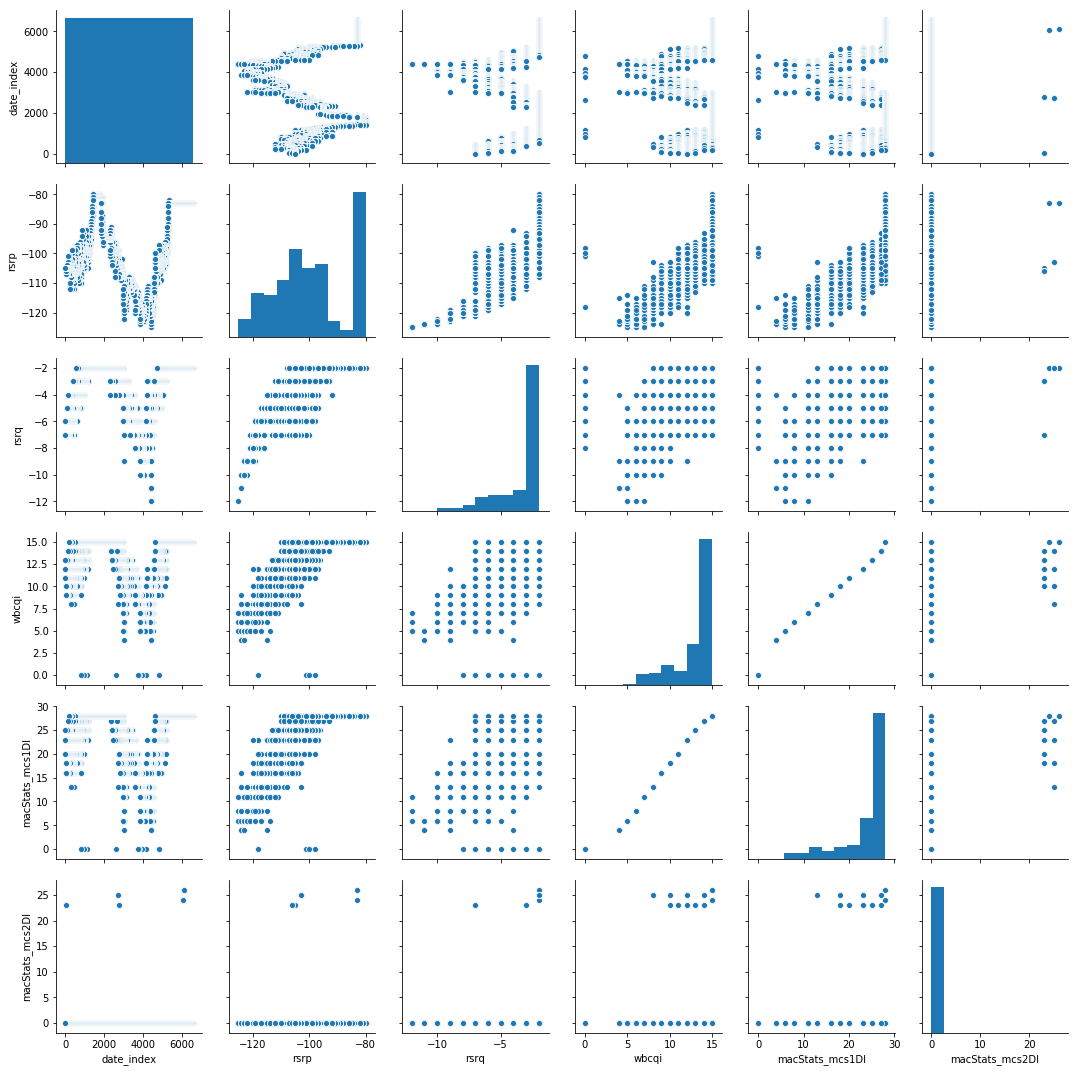

In [11]:
sns.pairplot(data2)

### A model to predict CQI
CQI (channel Quality Indicator) is a value that is used for calculating modulation and coding scheme, is usuaaly defecult to be determind. CQI is normally determind based on reported signal values from UE, i.e. RSRP and RSRQ however this is a complicated process and each UE vendor has its own method of determinding CQI. That is why we have decided to provide a model that can be trained on RSRP and RSRQ and predict CQI. This way the complicated calculation for CQI can be replaced with a ML model that produces CQI based on trained values.
Our goal is to predict the wbcqi based on the rsrp and rsrq.

Our featur set is 'date_index', 'rsrp','rsrq','wbcqi' but it can be seen that rsrp and rsrq are directly correlated, s it makes sense to remove one of them (rsrp, which has larger value range)) from our feature set

In [22]:
data3=data1[['date_index','rsrq','wbcqi']]
data2.head()

,date_index,rsrp,rsrq,wbcqi,macStats_mcs1Dl,macStats_mcs2Dl
0,6532,-83,-2,15,28,0
1,6531,-83,-2,15,28,0
2,6530,-83,-2,15,28,0
3,6529,-83,-2,15,28,0
4,6528,-83,-2,15,28,0


In [23]:
data3.set_index('date_index')
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6532 entries, 0 to 6531
Data columns (total 3 columns):
date_index    6532 non-null int64
rsrq          6532 non-null int64
wbcqi         6532 non-null int64
dtypes: int64(3)
memory usage: 153.2 KB


In [24]:
data3.describe()

,date_index,rsrq,wbcqi
count,6532.000000,6532.000000,6532.000000
mean,3266.500000,-3.539804,13.085732
std,1885.770311,2.078709,2.697702
min,1.000000,-12.000000,0.000000
25%,1633.750000,-5.000000,12.000000
50%,3266.500000,-2.000000,15.000000
75%,4899.250000,-2.000000,15.000000
max,6532.000000,-2.000000,15.000000


In [25]:
data3.to_csv('closerfarcloser3.csv')